## best deck yesterday

What this does:
- constrain data to yesterday
- find the decks with the highest winrate given a particular sample size
- show which archetypes those decks come from

In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import date
from datetime import timedelta
from fpdf import FPDF
from IPython.display import HTML
import os

from dateutil import parser
import datetime
import dataframe_image as dfi

os.chdir('../best_deck_yesterday')

In [135]:
df = pd.read_csv(r'./../data/raw/lor_ranked_data_all.csv')

In [136]:
this_day = str(date.today())
yesterday = str(date.today() - timedelta(days = 1))
df_date = df[(df['game_start_time_utc'] < this_day) & (df['game_start_time_utc'] > yesterday)] # keep only the games played yesterday
pdf_n_games_total = df_date.shape[0]

In [137]:
d = datetime.datetime.strptime(yesterday, '%Y-%m-%d')
pdf_yesterday = d.strftime('%b %d, %Y')

In [138]:
n = 200

# top 3 decks yesterday, regardless of archetype

In [139]:
archetypes = df_date['deck_code'].value_counts()
archetypes = archetypes[archetypes > n]
popular_list = list(archetypes.index)
x = df.loc[df['deck_code'].isin(popular_list)]

In [140]:
df_champ = x[x['game_outcome'] != "tie"] # get rid of ties
df_champ = df_champ.groupby(['deck_code', 'game_outcome']).size() # group deck codes by outcome
df_champ = df_champ.groupby(level=0).transform(lambda x: (x / x.sum()).round(3)*100) # get winrate
df_champ.drop('loss', level=1, axis=0, inplace=True) # drop losses
df_champ = df_champ.droplevel(level=1) # not sure
df_champ = df_champ.sort_values(ascending=False) # sort so good stuff at top
df_champ = pd.DataFrame({'deck_code':df_champ.index, 'winrate':df_champ.values}) #dataframe w/ column titles

In [141]:
df_ = df_date[['deck_code', 'archetype']].copy() # make a dataframe with just the stuff you need
_ = pd.merge(df_champ, df_, on=['deck_code'], copy=False).drop_duplicates().reset_index(drop=True)[:20] # get the archetypes for top decks, drop dupes, reset index, keep top 10

In [142]:
# get sample size for each deck
_['n_games'] = ""
for idx, i in enumerate(_['deck_code']):
    _['n_games'][idx] = df_date.deck_code.str.count(i).sum()

<ipython-input-142-ec9d281ced4c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _['n_games'][idx] = df_date.deck_code.str.count(i).sum()


In [143]:
_[:20]

,deck_code,winrate,archetype,n_games
0,CMCACBQBDYAQMBZSAQCACAIFBIHAMBAHBUPSYQSJPABACA...,57.4,Lissandra Taliyah,302
1,CECQCAQDBEAQMAY6AIAQGLRXAMAQKKBRGUBQIBJVGY3QIA...,56.5,Elise Viego (NX),332
2,CECQCAQDBEAQMAY6AIAQGLRXAMCAKNJWG4CACBIBFAYTKA...,55.9,Elise Viego (NX),321
3,CICACAYEAMAQIBAQAMAQIJRHGQCAGCJDJFLNSAICAIBQIB...,55.9,Aphelios Viktor,390
4,CQCACAQGFYBACAYTDMBQGAYBAMDQKBIKSEA2MANRAG3QDW...,55.7,Fizz Riven (BC),221
5,CQCQCAQGFYAQIAYWAIAQGEY3AMBQGAIDA4CAKCRRUYA3CA...,55.4,Fizz Riven (BC),288
6,CECACBAEBYBACBIBFABQCBAQDM4AIBIEBQLBQHIEAEAQIN...,54.9,Heimerdinger Jayce (SI),229
7,CICQCAYECIAQIBAQAEDASJQCAMEUTWIBAUAQIDBGE4WTIA...,54.6,Vi Zoe Aphelios,722
8,CUDACAIABEAQGAAOAECAADYBAYFBUAIGBQAQGBIABEFAYB...,54.0,Galio Bard,1087
9,CECQCAQDBEAQMAY6AIAQGLRXAIAQKKBRAMCAKNJWG4CACB...,53.9,Katarina Elise Viego,838


In [144]:
# define a bunch of variables
top_archetype = _['archetype'][0]
top_archetype_plays = df_date['archetype'].value_counts()[top_archetype]
top_winrate = round(_['winrate'][0])
top_deck_n_games = _['n_games'][0]

deck_wr0 = round(_['winrate'][0])
deck_wr1 = round(_['winrate'][1])
deck_wr2 = round(_['winrate'][2])

deck_code0 = _['deck_code'][0]
deck_code1 = _['deck_code'][1]
deck_code2 = _['deck_code'][2]

deck_archetype0 = _['archetype'][0]
deck_archetype1 = _['archetype'][1]
deck_archetype2 = _['archetype'][2]

In [145]:
top_archetype_plays

5579

In [146]:
pdf_n_games_total

71856

## yesterday's top 10 archetypes + wr

In [147]:
#clean data
df_small = df_date[['game_outcome', 'total_turn_count', 'archetype']]
archetypes = df_small['archetype'].value_counts() # find the unique archetypes being played
popular_archetypes = archetypes[archetypes > len(df_small)/50] #only keep popular archetypes ##################################################################################
popular_list = list(popular_archetypes.index) # make a list of popular archetypes
df_small_popular = df_small.loc[df['archetype'].isin(popular_list)] # filter df to only keep popular archetypes
df_small_popular = df_small_popular[df_small_popular['game_outcome'] != "tie"] # drop ties

#calculate winrate by archetype
df2 = df_small_popular.groupby(['archetype', 'game_outcome']).size() #get win/loss for major archetypes
df2 = df2.groupby(level=0).transform(lambda x: (x / x.sum()).round(2)*100) #get win/loss % for major archetypes
df2.drop('loss', level=1, axis=0, inplace=True) #drop loss %
df2 = df2.droplevel(level=1) #drop win/loss
df2 = df2.to_frame('winrate').reset_index()
df2 = df2.sort_values(by='winrate', ascending=False)
dfi.export(df2, "top_archetypes_winrate.png")

## generate graphs

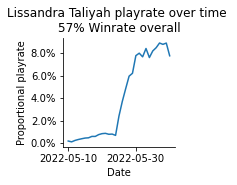

In [148]:
# proportional playrate chart
df_x = df[df['archetype'] == top_archetype] # make dataframe of just the best archetype
thing = df_x['game_start_time_utc'].str[:10] # just get the dates
games_arch = thing.value_counts() # how many games are played per day?
games_arch.sort_index(ascending=True, inplace=True) # sort the dates

# the total number of games played on any given day
_temp = df['game_start_time_utc'].str[:10]
_temp = _temp.value_counts()
_temp.sort_index(ascending=True, inplace=True)

# get % playrate
dates = games_arch.divide(_temp)
dates = round(dates*100, 3)

# plot
fig, ax = plt.subplots(figsize=(2,2)) # graph to see if you're missing any dates
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
plt.title(f'{top_archetype} playrate over time \n{deck_wr0}% Winrate overall')
plt.xlabel('Date')
plt.ylabel('Proportional playrate')
dates.plot(ax=ax, kind='line')
plt.savefig(f'archetypePopularity.png', bbox_inches="tight", dpi=200, transparent=True)

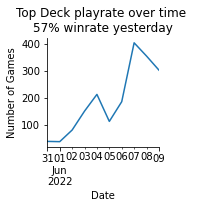

In [149]:
df_x = df[df['deck_code'] == deck_code0] # make dataframe of just the best deck
thing = pd.to_datetime(df_x['game_start_time_utc'].str[:10]) # just get the dates
dates = thing.value_counts() # how many games are played per day?
dates.sort_index(ascending=True, inplace=True) # sort the dates

fig, ax = plt.subplots(figsize=(2,2)) # graph to see if you're missing any dates
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title(f'Top Deck playrate over time \n{deck_wr0}% winrate yesterday')
plt.xlabel('Date')
plt.ylabel('Number of Games')
dates.plot(ax=ax, kind='line')
plt.savefig(f'deckPopularity.png', bbox_inches="tight", dpi=200, transparent=True)

## Generate html and convert to image

In [150]:
# import jinja2

# os.chdir('../best_deck_yesterday') # change directory

# #make top 10 archetypes table into html table
# _df2 = df2.to_frame('winrate').reset_index()
# top_archetype_html = _df2.to_html(classes='table table-stripped', index=False)
# text_file = open("top-ten-archentypes.html", "w")
# text_file.write(top_archetype_html)
# text_file.close()

# #vars
# title = f'What was the best deck on {pdf_yesterday}?'
# intro_text = f'I analyzed {pdf_n_games_total} games to discover yesterday\'s top-performing archetypes and decks'
# top_arch_intro = f'{top_archetype} is yesterdays top archetype. <br> Here are the 10 other best archetypes:'
# best_deck_intro = 'Here are the best decks from yesterday:'
# test = _.to_html(columns=['winrate', 'archetype', 'deck_code'],index=False, justify='left')
# graph_intro='This deck is new and this archetype is new'

# #make html file
# outputfile = 'myfile.html'
# subs = jinja2.Environment( 
#               loader=jinja2.FileSystemLoader('./')      
#               ).get_template('best-deck-yesterday.html').render(title=title, 
#                                                                 intro_text=intro_text, 
#                                                                 top_archetype_html=top_archetype_html,
#                                                                 top_arch_intro=top_arch_intro,
#                                                                best_deck_intro=best_deck_intro,
#                                                                test=test,
#                                                                graph_intro=graph_intro)

# # lets write the substitution to a file
# with open(outputfile,'w') as f: f.write(subs)

In [151]:
pdf = FPDF()

w = 210
h = 297

pdf.add_page()
pdf.set_text_color(50,50,50)
pdf.set_fill_color(252, 237, 218)
pdf.rect(0, 0, 210, 297, 'F')

# logo
pdf.image('logo.png', w-24, 1, w/8)
pdf.image('z.png', w-24, 1, w/8)

#title
pdf.set_font('Arial', 'B', 25)
pdf.ln(10)
pdf.write(5,f'What was the best deck on {pdf_yesterday}?')

#top archetypes
pdf.set_font('Arial', 'B', 10)
pdf.ln(5)
pdf.write(10,f'I analyzed {pdf_n_games_total} games to discover yesterday\'s top-performing archetypes and decks.')
#png of top 10
pdf.set_font('Arial', 'B', 15)
pdf.ln(10)
pdf.write(10,f'{top_archetype} is yesterday\'s top archetype.')
pdf.image("top_archetypes_winrate.png", w/2-20, 50, w/3.5)

# top decks
pdf.ln(100)
pdf.set_font('Arial', 'B', 15)
pdf.write(10,f'Here are the best decks in the {df2.index[0]} archetype:')
pdf.ln(10)
pdf.set_font('Arial', 'B', 7.5)
pdf.write(10,f'{deck_wr0}% wr | {deck_code0} \n{deck_wr1}% wr | {deck_code1} \n{deck_wr2}% wr | {deck_code2}')
# pdf.write(10,f'{deck_wr_0}% wr | {deck_0} \n{deck_wr_1}% wr | {deck_1}')#' \n{deck_wr_2}% wr | {deck_2}')
# pdf.write(10,f'{deck_wr_0}% wr | {deck_0}')#' \n{deck_wr_1}% wr | {deck_1} \n{deck_wr_2}% wr | {deck_2}')
pdf.ln(10)
pdf.set_font('Arial', 'B', 6)
pdf.write(7,f'\t\t\t\t\t\t\t\t\t\t\t\t\t*Each deck must have at least 150 wins to be considered.')

#optimal game length
pdf.ln(10)
pdf.set_font('Arial', 'B', 15)
pdf.write(10,'This archetype used to be good and is making a comeback, and this deck is new to the meta.')
pdf.image('archetypePopularity.png', 10, h-95, w/2.2)

#optimal game length
# pdf.ln(10)
# pdf.set_font('Arial', 'B', 15)
# pdf.write(0,'Has this deck always been popular?')
pdf.image('deckPopularity.png', w/2, h-95, w/2.2)

#export
pdf.output(f'{pdf_yesterday}.pdf', 'F')

''

## Generate Post

In [152]:
print(f'Yesterday\'s top deck is an {top_archetype} deck with a {top_winrate}% winrate. \
      \nOut of {pdf_n_games_total} matches analyzed, {top_archetype} was played {top_archetype_plays} times ({round((top_archetype_plays/pdf_n_games_total)*100)}%). Its top deck was played {top_deck_n_games} times with an overall {top_winrate}% winrate. \
      \n\n|Winrate|Archetype|Deck Code|\
      \n|:-|:-|:-| \
      \n|{deck_wr0}%|{deck_archetype0}|{deck_code0}| \
      \n|{deck_wr1}%|{deck_archetype1}|{deck_code1}|  \
      \n|{deck_wr2}%|{deck_archetype2}|{deck_code2}|\
      \n\nHappy climbing, and all hail Balco for the data!')

Yesterday's top deck is an Lissandra Taliyah deck with a 57% winrate.       
Out of 71856 matches analyzed, Lissandra Taliyah was played 5579 times (8%). Its top deck was played 302 times with an overall 57% winrate.       

|Winrate|Archetype|Deck Code|      
|:-|:-|:-|       
|57%|Lissandra Taliyah|CMCACBQBDYAQMBZSAQCACAIFBIHAMBAHBUPSYQSJPABACAIBGIAQIBZ3AA|       
|56%|Elise Viego (NX)|CECQCAQDBEAQMAY6AIAQGLRXAMAQKKBRGUBQIBJVGY3QIAIEAUIACBQDBYAQMBJLAIAQKAIZAA|        
|56%|Elise Viego (NX)|CECQCAQDBEAQMAY6AIAQGLRXAMCAKNJWG4CACBIBFAYTKAQBAECRSAIGAMHAGAIDAMGQCBAFCAAQMBJL|      

Happy climbing, and all hail Balco for the data!


In [153]:
print(f'for the mobile homies: \
    \n (({deck_code0})) \
     \n (({deck_code1})) \
      \n (({deck_code2}))')

for the mobile homies:     
 ((CMCACBQBDYAQMBZSAQCACAIFBIHAMBAHBUPSYQSJPABACAIBGIAQIBZ3AA))      
 ((CECQCAQDBEAQMAY6AIAQGLRXAMAQKKBRGUBQIBJVGY3QIAIEAUIACBQDBYAQMBJLAIAQKAIZAA))       
 ((CECQCAQDBEAQMAY6AIAQGLRXAMCAKNJWG4CACBIBFAYTKAQBAECRSAIGAMHAGAIDAMGQCBAFCAAQMBJL))


In [154]:
_ = pd.merge(df_champ, df_, on=['deck_code'], copy=False).drop_duplicates().reset_index(drop=True)
_['deck_code'][2]

'CECQCAQDBEAQMAY6AIAQGLRXAMCAKNJWG4CACBIBFAYTKAQBAECRSAIGAMHAGAIDAMGQCBAFCAAQMBJL'